Epoch 0, Loss: 2.03164,k = 1.0010
Epoch 100, Loss: 1.82190,k = 1.1072
Epoch 200, Loss: 1.59903,k = 1.2269
Epoch 300, Loss: 1.36629,k = 1.3613
Epoch 400, Loss: 1.12904,k = 1.5106
Epoch 500, Loss: 0.89485,k = 1.6744
Epoch 600, Loss: 0.67324,k = 1.8505
Epoch 700, Loss: 0.47479,k = 2.0350
Epoch 800, Loss: 0.30928,k = 2.2215
Epoch 900, Loss: 0.18313,k = 2.4013
Epoch 1000, Loss: 0.09703,k = 2.5644
Epoch 1100, Loss: 0.04543,k = 2.7022
Epoch 1200, Loss: 0.01866,k = 2.8092
Epoch 1300, Loss: 0.00673,k = 2.8855
Epoch 1400, Loss: 0.00214,k = 2.9355
Epoch 1500, Loss: 0.00060,k = 2.9658
Epoch 1600, Loss: 0.00015,k = 2.9828
Epoch 1700, Loss: 0.00003,k = 2.9919
Epoch 1800, Loss: 0.00001,k = 2.9963
Epoch 1900, Loss: 0.00000,k = 2.9984
Epoch 2000, Loss: 0.00000,k = 2.9994
Epoch 2100, Loss: 0.00000,k = 2.9998
Epoch 2200, Loss: 0.00000,k = 2.9999
Epoch 2300, Loss: 0.00000,k = 3.0000
Epoch 2400, Loss: 0.00000,k = 3.0000
Epoch 2500, Loss: 0.00000,k = 3.0000
Epoch 2600, Loss: 0.00000,k = 3.0000
Epoch 2700, L

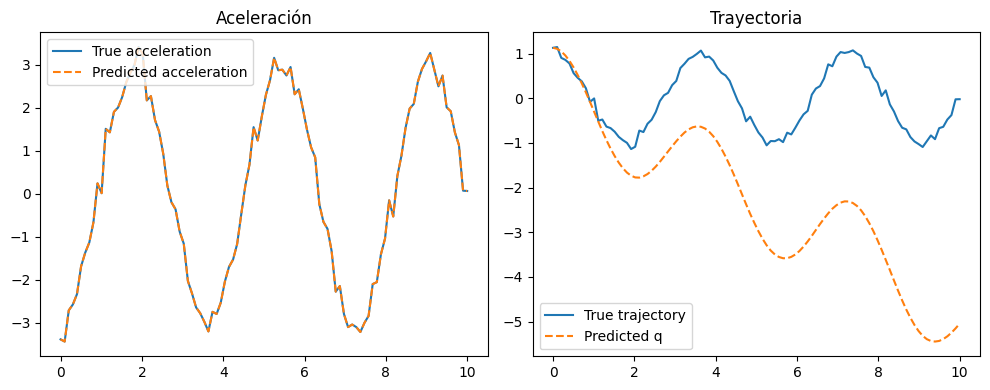

In [9]:
# This code serves as a guide for replication and further development of LNNs, consequently its heavily commented and explained.
# This code stems from various sources, along the code it will be commented in detail and the sources cited from which the code stems
# I was heavily influenced by Cranmer´s form of implementation of LNNs (https://github.com/MilesCranmer/lagrangian_nns) however there are
# not many simple LNNs available from which to learn, therefore AI was used as a guide to know the steps the code should follow (I wrote the code) and for
# debugging and optimization of the performace of the code.


import jax
import jax.numpy as jnp
from jax import grad, jacobian, hessian, vmap, random
import optax
import flax.linen as nn
from flax.training import train_state
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from scipy.ndimage import gaussian_filter1d

k = 3.0
m = 1.0

# Simulated data
def data(num_points, t_max, key=None):
    t = jnp.linspace(0, t_max, num_points)

    # Initial conditions
    q0, v0 = 1.0, 0.0
    omega = jnp.sqrt(k/m)

    # Implementation of analytical solution to differential equation
    random_noise = 0.08 * random.normal(key, (num_points,))

    q = q0 * jnp.cos(omega * t) + random_noise

    q_dot = -omega *(q0 *jnp.sin(omega*t) + random_noise)

    q_ddot = -omega**2 * q

    return t, q, q_dot, q_ddot

# Generate dataset with a random noise
key = random.PRNGKey(0)
t, q, q_dot, q_ddot = data(num_points=100, t_max=10, key=key)


# Definition of LNN (Standard) and https://keras.io/2/api/models/model/
class LNN(nn.Module):
    log_k: float = 0.0 # Ks are trained as log k to maintain their positivity, suggested by AI
    m: float = 1.0

    @nn.compact # debug solution suggested by AI homologous to structure used in PINN
    def __call__(self, q, q_dot):
        log_k = self.param('log_k', lambda _: self.log_k)
        k = jnp.exp(log_k)
        T = 0.5 * self.m *q_dot**2
        V = 0.5 * k * q**2
        return T - V


# Definition of Lagrangian calculates lagrangian by LNN and returns acceleration which is a parameter that can be integrated to get q

def lagrangian(LNN_returnable, params, q, q_dot):

  def Lagrangian_from_LNN( q, q_dot):
    #call LNN to return value of Lagrangian
    return LNN_returnable.apply(params, q, q_dot).squeeze()

  #the change between sec and outer determines the double derivate either q (0) o q´ (1)
  sec = jacobian(grad(Lagrangian_from_LNN, 1), 0)(q, q_dot)
  par = grad(Lagrangian_from_LNN, 0)(q, q_dot) - jnp.matmul(sec, q_dot)

  outer = jacobian(grad(Lagrangian_from_LNN, 1), 1)(q, q_dot)
  H = hessian(Lagrangian_from_LNN, 1)(q, q_dot)

  q_ddot_pred = jnp.linalg.pinv(H) @ par
  return q_ddot_pred



# Loss Function
def loss_function(params, model, q, q_dot, q_ddot_data):
    # Standard function used in other LNN codes https://docs.jax.dev/en/latest/_autosummary/jax.vmap.html, the q[None] was a suggested way by AI to optimize adding a new dimension
    q_ddot_pred = vmap(lambda q, q_dot: lagrangian(model, params, q[None], q_dot[None]))(q, q_dot)
    # Equivalent to tensorflow´s reduce_mean
    return jnp.mean((q_ddot_pred.squeeze() - q_ddot_data)**2)


# Standard procedure for jax https://flax.readthedocs.io/en/latest/guides/linen_to_nnx.html#using-trainstate-in-flax-nnx , initialices de model LNN, defines params, model an optimizer
def create_train_state(rng, model, learning_rate=1e-3):
    params = model.init(rng, jnp.ones((1,)), jnp.ones((1,)))
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optax.adam(learning_rate))
@jax.jit
def train(state, q, q_dot, q_ddot):
    loss, grads = jax.value_and_grad(loss_function)(state.params, model, q, q_dot, q_ddot)
    state = state.apply_gradients(grads=grads)
    return state, loss


# Call model and train
key = jax.random.PRNGKey(0)
model = LNN()
state = create_train_state(key, model)

losses_general = []

#Same as in PINN
for epoch in range(5000):
    state, loss = train(state, q, q_dot, q_ddot)
    losses_general.append(loss)

    #(Standard)
    log_k_pred = state.params['params']['log_k']

    k_pred = jnp.exp(log_k_pred)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.5f},k = {k_pred:.4f}")

log_k_pred= state.params['params']['log_k']
k_pred = jnp.exp(log_k_pred)
print(f"Predicción constante de elasticidad k = {k_pred:.4f}")



# Predict acceleration
q_ddot_pred = vmap(lambda q, q_dot: lagrangian(model, state.params, q[None], q_dot[None]))(q, q_dot).squeeze()



# Forward Euler definition, I tried several integration methods these were the best results

dt = t[1] - t[0]

v_pred = jnp.zeros_like(q_ddot_pred)
q_pred = jnp.zeros_like(q_ddot_pred)

v_pred = v_pred.at[0].set(q_dot[0])
q_pred = q_pred.at[0].set(q[0])

for i in range(1, len(t)):
    v_pred = v_pred.at[i].set(v_pred[i-1] +q_ddot_pred[i-1] * dt)
    q_pred = q_pred.at[i].set(q_pred[i-1] + v_pred[i-1] *dt)



# Graph
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(t, q_ddot, label='True acceleration')
plt.plot(t, q_ddot_pred, '--', label='Predicted acceleration')
plt.title('Aceleración')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, q, label='True trajectory')
plt.plot(t, q_pred, '--', label='Predicted q')
plt.title('Trayectoria')
plt.legend()
plt.tight_layout()
plt.show()


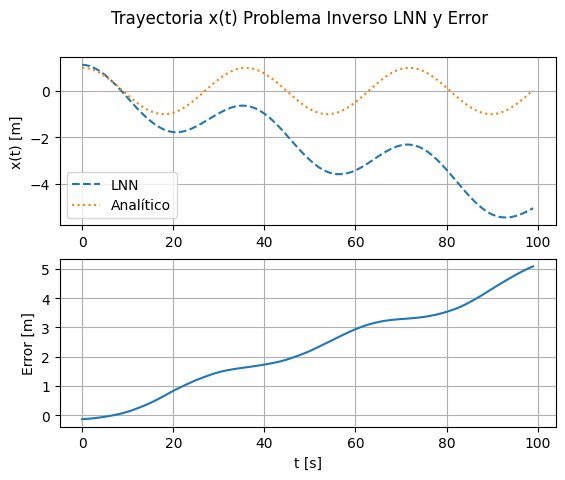

In [2]:
fig, axs = plt.subplots(2)
fig.suptitle('Trayectoria x(t) Problema Inverso LNN y Error')

axs[0].plot(q_pred, label='LNN', linestyle='--')
axs[0].set( ylabel='x(t) [m]')
axs[0].grid()
axs[0].legend(loc='upper right')
axs[0].plot(np.cos(np.sqrt(3)*t), label='Analítico', linestyle='dotted')
axs[0].legend()


axs[1].plot(-q_pred + np.cos(np.sqrt(3)*t))
axs[1].set(xlabel='t [s]', ylabel='Error [m]')
axs[1].grid()